<a href="https://colab.research.google.com/github/Meeseek5/GuitarChordClassifier/blob/main/guitar_chord_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#吉他和弦辨識模型

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tflite-model-maker

In [ ]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

# 查看版本
print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

print(f"GPU: {tf.test.gpu_device_name()}")

TensorFlow Version: 2.7.0
Model Maker Version: 0.3.4
GPU: 


解壓縮法一

In [ ]:
from zipfile import ZipFile
file_name = "chord_audio_dataset.zip"

# 'r' --> 表示讀檔
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

解壓縮法二

In [ ]:
!unzip chord_audio_dataset.zip -d chord_audio_dataset

Archive:  chord_audio_dataset.zip
   creating: chord_audio_dataset/chord_audio_dataset_2/
   creating: chord_audio_dataset/chord_audio_dataset_2/test/
   creating: chord_audio_dataset/chord_audio_dataset_2/test/A/
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_01.wav  
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_02.wav  
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_03.wav  
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_04.wav  
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_05.wav  
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_06.wav  
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_07.wav  
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_08.wav  
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_09.wav  
  inflating: chord_audio_dataset/chord_audio_dataset_2/test/A/a_chord_10.wa

In [ ]:

data_dir = './dataset/chord_audio_dataset'

chord_code_to_name = {
  'A': 'A Chord',
  'C': 'C Chord',
  'D': 'D Chord',  
  'E': 'E Chord',
  'F': 'F Chord', 
  'G': "G Chord",  
}


chord_images = {
  'A': 'https://jguitar.com/images/chordshape/A-Major-A-x%2C0%2C2%2C2%2C2%2C0.png',    
  'C': 'https://jguitar.com/images/chordshape/C-Major-C-x%2C3%2C2%2C0%2C1%2C0.png',   
  'D': 'https://jguitar.com/images/chordshape/D-Major-D-x%2Cx%2C0%2C2%2C3%2C2.png',  
  'E': 'https://jguitar.com/images/chordshape/E-Major-E-0%2C2%2C2%2C1%2C0%2C0.png',   
  'F': 'https://jguitar.com/images/chordshape/F-Major-F-1%2C3%2C3%2C2%2C1%2C1.png', 
  'G': 'https://jguitar.com/images/chordshape/G-Major-G-3%2C2%2C0%2C0%2C0%2C3.png'
}


test_files = os.path.abspath(os.path.join(data_dir, 'test/*/*.wav'))

def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path

def show_chord_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')

  # 查看音檔資料
  print(f'sample_rate: {sample_rate}')
  print(f'audio_data: {audio_data}')
  print(f'音檔的資料數: {audio_data.shape}')

  chord_code = audio_path.split('/')[-2] 
  print(f'Chord name: {chord_code_to_name[chord_code]}')
  print(f'Chord code: {chord_code}')
  display(Image(chord_images[chord_code]))

  plttitle = f'{chord_code_to_name[chord_code]} ({chord_code})'
  plt.title(plttitle)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

print('functions and data structures created')


functions and data structures created


sample_rate: 16000
audio_data: [0 0 0 ... 0 0 2]
音檔的資料數: (70656,)
Chord name: G Chord
Chord code: G


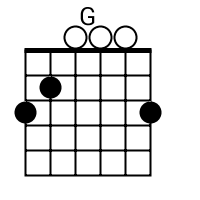

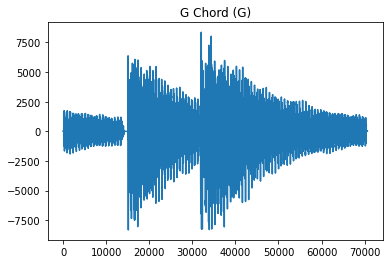

In [ ]:
random_audio = get_random_audio_file()
show_chord_data(random_audio)


設定規格

In [ ]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step= (audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH//14), # 3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH
    frame_length= (audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH//7)) # 6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH

INFO:tensorflow:Checkpoints are stored in /tmp/tmplsj636do


載入資料

In [ ]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

In [ ]:
batch_size = 128
epochs = 100

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 6)                6150      
                                                                 
Total params: 6,150
Trainable params: 6,150
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
143/143 [==============================] - 169s 1s/step - loss: 2.1790 - acc: 0.1930 - val_loss: 1.9782 - val_acc: 0.1200
Epoch 2/100
143/143 [==============================] - 3s 20ms/step - loss: 2.0665 - acc: 0.2110 - val_loss: 1.9852 - val_acc: 0.1711
Epoch 3/100
143/143 [==============================] - 3s 21ms/step - loss: 2.0656 - acc: 0.2189 - val_loss: 2.0234 - val_acc: 0.1676
Epoch 4/100
143/143 [==============================] - 3s 19ms/step - loss: 2.0741 - acc: 0.2243 - val_loss: 1.8834 - val_acc: 0.1765
Epoch 5/100
143/143 [======

In [ ]:
print('Evaluating the model')
model.evaluate(test_data)


Evaluating the model
155/155 [==============================] - 37s 235ms/step - loss: 2.3169 - acc: 0.1549


[2.316924571990967, 0.15494950115680695]